## Load Spotify API

In [3]:
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import json

In [4]:
with open('./config.json') as f:
    config = json.load(f)
client_id = config['client_id']
client_secret = config['client_secret']
redirect_uri='https://www.google.com/'

In [5]:
username = config['username']
client_creds_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
scope = "user-library-read playlist-read-private"
try:
    token = util.prompt_for_user_token(username, scope, client_id=client_id, 
                                       client_secret=client_secret, redirect_uri=redirect_uri)
    sp = spotipy.Spotify(auth=token)
except:
    print(f'token is not accessible for {username}')

## Grab Data from Spotify API

In [6]:
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
playlist_dict = {
    "Get Turnt": "37i9dQZF1DWY4xHQp97fN6",
    "Classical Essentials": "37i9dQZF1DWWEJlAGA9gs0", #37i9dQZF1DXaXB8fQg7xif
    "Rock Save the Queen" : "37i9dQZF1DXcDnIr0iKAG8",
    "Coffee Table Jazz" : "37i9dQZF1DWVqfgj8NZEp1"
}
spotify_username = 'Spotify'

In [8]:
# Load the playlists into objects
playlists = [sp.user_playlist(spotify_username, playlist_id=v) for _, v in playlist_dict.items()]

In [9]:
def extract_playlist_info(playlists):
    df_playlists = []
    for playlist in playlists:
        playlist_items = playlist['tracks']['items']
        df_playlist = pd.DataFrame(columns=('song_id', 'song_name', 'song_artist'))
        for item in playlist_items:
            track = item['track']
            df_playlist = df_playlist.append(
                {
                    'song_id': track['id'],
                    'song_name': track['name'],
                    'song_artist': track['artists'][0]['name']
                },
                ignore_index=True
            )
        df_playlists.append(df_playlist)
    return df_playlists

In [10]:
def extract_audio_features(df_playlists):
    df_features_list = []
    columns = ['song_name', 'danceability', 'energy', 'key', 'loudness', 'mode', 
            'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo']
    for df_playlist in df_playlists:
        song_ids = list(df_playlist['song_id'])
        df_audio_features = pd.DataFrame(data=sp.audio_features(tracks=song_ids))
        
        df_features = df_audio_features[columns[1:]].join(df_playlist['song_name'])
        df_features_list.append(df_features[columns]) # put columns inside to make sure song_name 
                                                      #is the first column.
    return df_features_list

In [11]:
df_playlists = extract_playlist_info(playlists)
df_features_list = extract_audio_features(df_playlists)
pprint(df_features_list[0].loc[4])
print()
pprint(df_features_list[2].loc[8])

song_name           Pure Water (with Migos)
danceability                           0.68
energy                                0.559
key                                       0
loudness                             -5.545
mode                                      1
speechiness                           0.129
acousticness                          0.172
instrumentalness                          0
valence                               0.137
tempo                               202.006
Name: 4, dtype: object

song_name           California
danceability             0.432
energy                   0.684
key                          2
loudness                 -5.23
mode                         0
speechiness              0.199
acousticness           0.00279
instrumentalness             0
valence                   0.44
tempo                   181.89
Name: 8, dtype: object


## Setting up Training Data

In [12]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [13]:
def convert_df_to_array(df):
    converted_list = []
    for _, row in df.iterrows():
        converted_list.append(np.array(list(row[1:])))  # use 1: to avoid adding in song name
    return np.asarray(converted_list)

In [14]:
def create_X_data(df_features_list):
    X = []
    for df_features in df_features_list:
        converted_array = convert_df_to_array(df_features)
        for item in converted_array:
            X.append(item)
    return np.asarray(X)

In [15]:
def create_y_data():
    y = np.array([])
    for i in range(0, 4):
        y = np.append(y, np.ones(shape=(100, 1)) * i)
    return y

In [16]:
X = create_X_data(df_features_list) 
X.shape

(400, 10)

In [17]:
y = to_categorical(create_y_data())
y.shape

(400, 4)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42) # data set small
                                                                                          # so smaller test size
X_train.shape, y_train.shape

((360, 10), (360, 4))

## Create Model

In [19]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from sklearn.metrics import confusion_matrix

In [20]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Model V1

In [21]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=10))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

In [22]:
sgd = SGD()
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=90, epochs=30)

Epoch 1/30
360/360 [==============================] - 0s 959us/step - loss: 10.6342 - acc: 0.2306
Epoch 2/30
360/360 [==============================] - 0s 27us/step - loss: 9.6480 - acc: 0.2917
Epoch 3/30
360/360 [==============================] - 0s 30us/step - loss: 10.5677 - acc: 0.2417
Epoch 4/30
360/360 [==============================] - 0s 44us/step - loss: 8.6006 - acc: 0.2778
Epoch 5/30
360/360 [==============================] - 0s 33us/step - loss: 6.2807 - acc: 0.3194
Epoch 6/30
360/360 [==============================] - 0s 38us/step - loss: 3.1967 - acc: 0.3056
Epoch 7/30
360/360 [==============================] - 0s 49us/step - loss: 1.5806 - acc: 0.3111
Epoch 8/30
360/360 [==============================] - 0s 36us/step - loss: 1.2837 - acc: 0.4056
Epoch 9/30
360/360 [==============================] - 0s 28us/step - loss: 1.2978 - acc: 0.4194
Epoch 10/30
360/360 [==============================] - 0s 26us/step - loss: 1.3147 - acc: 0.4028
Epoch 11/30
360/360 [===============

In [23]:
model.evaluate(X_test, y_test, batch_size=90)

40/40 [==============================] - 0s 509us/step


[1.2932331562042236, 0.42500001192092896]

In [24]:
y_pred = model.predict(X_test)
y_pred

array([[ 0.25998628,  0.23136592,  0.2614556 ,  0.2471922 ],
       [ 0.25998628,  0.23136592,  0.2614556 ,  0.2471922 ],
       [ 0.25868014,  0.23243004,  0.26079297,  0.2480969 ],
       [ 0.25998628,  0.23136592,  0.2614556 ,  0.2471922 ],
       [ 0.25998628,  0.23136592,  0.2614556 ,  0.2471922 ],
       [ 0.25998628,  0.23136592,  0.2614556 ,  0.2471922 ],
       [ 0.25998628,  0.23136592,  0.2614556 ,  0.2471922 ],
       [ 0.25998628,  0.23136592,  0.2614556 ,  0.2471922 ],
       [ 0.25998628,  0.23136592,  0.2614556 ,  0.2471922 ],
       [ 0.06594671,  0.56405973,  0.09087522,  0.27911833],
       [ 0.25998628,  0.23136592,  0.2614556 ,  0.2471922 ],
       [ 0.22386836,  0.26874891,  0.22628503,  0.2810978 ],
       [ 0.25998628,  0.23136592,  0.2614556 ,  0.2471922 ],
       [ 0.25998628,  0.23136592,  0.2614556 ,  0.2471922 ],
       [ 0.25998628,  0.23136592,  0.2614556 ,  0.2471922 ],
       [ 0.25998628,  0.23136592,  0.2614556 ,  0.2471922 ],
       [ 0.25998628,  0.

Confusion matrix, without normalization
[[ 0  0 12  0]
 [ 0  3  3  3]
 [ 0  0 10  1]
 [ 0  2  2  4]]


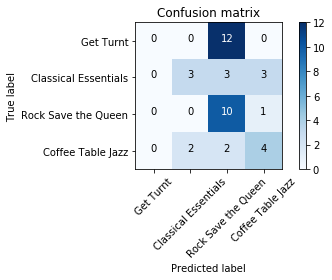

In [25]:
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=playlist_dict, normalize=False,
                      title='Confusion matrix')
plt.show()

Looking at this confusion matrix, I notice 3 things.
1. Testing dataset is very small. I need to expand my total data set
2. Coffee table jazz and Get Turnt are not being classfied correctly. Exploration is needed to see why
3. Rock save the queen is doing quite well. Exploration is needed to see why.

### Model V2

In [26]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=10))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax'))

In [27]:
sgd = SGD()
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
model.fit(X_train, y_train, batch_size=60, epochs=150)
model.evaluate(X_test, y_test, batch_size=60)

Epoch 1/150
300/300 [==============================] - 0s 1ms/step - loss: 8.6428 - acc: 0.2833
Epoch 2/150
300/300 [==============================] - 0s 53us/step - loss: 10.3657 - acc: 0.2133
Epoch 3/150
300/300 [==============================] - 0s 50us/step - loss: 8.1206 - acc: 0.2567
Epoch 4/150
300/300 [==============================] - 0s 49us/step - loss: 1.9235 - acc: 0.3567
Epoch 5/150
300/300 [==============================] - 0s 63us/step - loss: 1.1794 - acc: 0.4400
Epoch 6/150
300/300 [==============================] - 0s 51us/step - loss: 1.2167 - acc: 0.4033
Epoch 7/150
300/300 [==============================] - 0s 54us/step - loss: 1.2078 - acc: 0.4133
Epoch 8/150
300/300 [==============================] - 0s 69us/step - loss: 1.1186 - acc: 0.4233
Epoch 9/150
300/300 [==============================] - 0s 73us/step - loss: 1.1110 - acc: 0.4533
Epoch 10/150
300/300 [==============================] - 0s 41us/step - loss: 1.0703 - acc: 0.4333
Epoch 11/150
300/300 [=======

[0.74694790840148928, 0.61000000238418584]

Confusion matrix, without normalization
[[ 7  0 23  1]
 [ 0 14  0  7]
 [ 1  0 24  0]
 [ 1  6  0 16]]


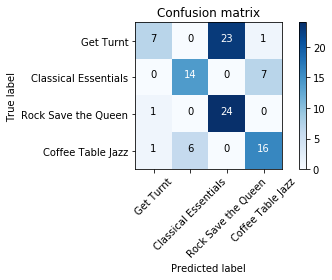

In [29]:
y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=playlist_dict, normalize=False,
                      title='Confusion matrix')
plt.show()

Changing the amount of neurons in the first layer, drop out rate, batch size and epochs makes quite a big difference. The new model has a more consistent accuracy, a significant improvement from the first version. 
I feel that data exploration is still needed. Maybe I need to change my dataset and eliminate some redundant columns.
Data Exploration will help me indicate what I columns would be most unique.

## Exploration

In [30]:
def get_feature(column, operation):
    categories = ['Get Turnt', 'Classical Essentials', 'Rock Save The Queen', 'Coffee Table Jazz']
    idx = 0
    for df_feature in df_features_list:
        if operation == 'mean':
            result = df_feature[column].mean()
        elif operation == 'std':
            result = df_feature[column].std()
        elif operation == 'var':
            result = df_feature[column].var()
        print(f'{operation} for {categories[idx]} is: {result}')
        idx += 1

In [31]:
def get_features(columns, operation):
    for column in columns:
        print(f'Feature: {column}')
        get_feature(column, operation)
        print()

In [32]:
columns = df_features_list[0].columns[1:]
get_features(columns, 'mean')

Feature: danceability
mean for Get Turnt is: 0.8199299999999999
mean for Classical Essentials is: 0.259256
mean for Rock Save The Queen is: 0.46502000000000004
mean for Coffee Table Jazz is: 0.4407500000000001

Feature: energy
mean for Get Turnt is: 0.6375
mean for Classical Essentials is: 0.11576170000000001
mean for Rock Save The Queen is: 0.8426900000000002
mean for Coffee Table Jazz is: 0.13658599999999999

Feature: key
mean for Get Turnt is: 5.09
mean for Classical Essentials is: 5.39
mean for Rock Save The Queen is: 5.02
mean for Coffee Table Jazz is: 5.1

Feature: loudness
mean for Get Turnt is: -6.157150000000001
mean for Classical Essentials is: -23.28731
mean for Rock Save The Queen is: -4.62875
mean for Coffee Table Jazz is: -18.281470000000002

Feature: mode
mean for Get Turnt is: 0.54
mean for Classical Essentials is: 0.66
mean for Rock Save The Queen is: 0.61
mean for Coffee Table Jazz is: 0.63

Feature: speechiness
mean for Get Turnt is: 0.20607899999999998
mean for Clas

In [33]:
columns = ['key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo']
get_features(columns, 'std')

Feature: key
std for Get Turnt is: 3.7446122912954833
std for Classical Essentials is: 3.22520064366842
std for Rock Save The Queen is: 3.9999494946306458
std for Coffee Table Jazz is: 3.445096060879416

Feature: loudness
std for Get Turnt is: 1.845915514963737
std for Classical Essentials is: 6.75518373897955
std for Rock Save The Queen is: 1.2852286466782572
std for Coffee Table Jazz is: 4.646458117695127

Feature: mode
std for Get Turnt is: 0.5009082659620331
std for Classical Essentials is: 0.47609522856952335
std for Rock Save The Queen is: 0.4902071300001973
std for Coffee Table Jazz is: 0.4852365870939097

Feature: speechiness
std for Get Turnt is: 0.11962027656148629
std for Classical Essentials is: 0.009136107685243408
std for Rock Save The Queen is: 0.0413853521517852
std for Coffee Table Jazz is: 0.008175909179356807

Feature: acousticness
std for Get Turnt is: 0.09083253277234091
std for Classical Essentials is: 0.0910103779186137
std for Rock Save The Queen is: 0.038656935

Looking at the means and Std Dev of the features, I can see that features with similar/close means may are not 'unique' features for the model. Furthermore, the features with similar means to one another and relatively close Std devs would be features that I may not want to use anymore. Features such as: tempo, key, mode, loudness. Speechiness is a feature that I could remove but I feel that the variation in values from category to category for this features may be more beneficial for the model.

## Model Revision 

### Change Training and Testing Data

In [49]:
new_data_columns = ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'valence']

In [50]:
def rev_convert_df_to_array(df):
    converted_list = []
    for _, row in df.iterrows():
        converted_list.append(np.array(list(row)))
    return np.asarray(converted_list)

In [51]:
def rev_create_X_data(df_features_list):
    X = []
    for df_features in df_features_list:
        converted_array = rev_convert_df_to_array(df_features[new_data_columns])
        for item in converted_array:
            X.append(item)
    return np.asarray(X)

In [52]:
def rev_create_y_data():
    y = np.array([])
    for i in range(0, 4):
        y = np.append(y, np.ones(shape=(100, 1)) * i)
    return y

In [53]:
X = rev_create_X_data(df_features_list) 
X.shape

(400, 6)

In [54]:
y = to_categorical(rev_create_y_data())
y.shape

(400, 4)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, y_train.shape

((300, 6), (300, 4))

### Model V3

In [300]:
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [301]:
sgd = SGD()
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [302]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
history = model.fit(X_train, y_train, batch_size=10, epochs=300, validation_data=(X_test, y_test))
model.evaluate(X_test, y_test, batch_size=10)

Train on 300 samples, validate on 100 samples
Epoch 1/300
300/300 [==============================] - 2s 7ms/step - loss: 1.3636 - acc: 0.3633 - val_loss: 1.3423 - val_acc: 0.6900
Epoch 2/300
300/300 [==============================] - 0s 671us/step - loss: 1.3231 - acc: 0.6500 - val_loss: 1.3061 - val_acc: 0.7600
Epoch 3/300
300/300 [==============================] - 0s 521us/step - loss: 1.2849 - acc: 0.7667 - val_loss: 1.2671 - val_acc: 0.7100
Epoch 4/300
300/300 [==============================] - 0s 591us/step - loss: 1.2419 - acc: 0.7500 - val_loss: 1.2223 - val_acc: 0.7200
Epoch 5/300
300/300 [==============================] - 0s 636us/step - loss: 1.1899 - acc: 0.7200 - val_loss: 1.1658 - val_acc: 0.7200
Epoch 6/300
300/300 [==============================] - 0s 438us/step - loss: 1.1289 - acc: 0.7100 - val_loss: 1.1018 - val_acc: 0.7000
Epoch 7/300
300/300 [==============================] - 0s 483us/step - loss: 1.0597 - acc: 0.6833 - val_loss: 1.0298 - val_acc: 0.7300
Epoch 8/300

Epoch 61/300
300/300 [==============================] - 0s 552us/step - loss: 0.2342 - acc: 0.8967 - val_loss: 0.2402 - val_acc: 0.8800
Epoch 62/300
300/300 [==============================] - 0s 461us/step - loss: 0.2378 - acc: 0.9000 - val_loss: 0.2216 - val_acc: 0.9100
Epoch 63/300
300/300 [==============================] - 0s 465us/step - loss: 0.2354 - acc: 0.9033 - val_loss: 0.2240 - val_acc: 0.9300
Epoch 64/300
300/300 [==============================] - 0s 458us/step - loss: 0.2265 - acc: 0.9033 - val_loss: 0.2485 - val_acc: 0.8800
Epoch 65/300
300/300 [==============================] - 0s 521us/step - loss: 0.2258 - acc: 0.8967 - val_loss: 0.2337 - val_acc: 0.9000
Epoch 66/300
300/300 [==============================] - 0s 517us/step - loss: 0.2269 - acc: 0.8900 - val_loss: 0.2365 - val_acc: 0.9100
Epoch 67/300
300/300 [==============================] - 0s 550us/step - loss: 0.2315 - acc: 0.9000 - val_loss: 0.2275 - val_acc: 0.9100
Epoch 68/300
300/300 [==========================

300/300 [==============================] - 0s 454us/step - loss: 0.1924 - acc: 0.9167 - val_loss: 0.4176 - val_acc: 0.8300
Epoch 122/300
300/300 [==============================] - 0s 493us/step - loss: 0.2156 - acc: 0.8967 - val_loss: 0.2998 - val_acc: 0.8800
Epoch 123/300
300/300 [==============================] - 0s 457us/step - loss: 0.2059 - acc: 0.9067 - val_loss: 0.2185 - val_acc: 0.9000
Epoch 124/300
300/300 [==============================] - 0s 507us/step - loss: 0.2052 - acc: 0.9233 - val_loss: 0.1984 - val_acc: 0.9100
Epoch 125/300
300/300 [==============================] - 0s 536us/step - loss: 0.2029 - acc: 0.9133 - val_loss: 0.2073 - val_acc: 0.9200
Epoch 126/300
300/300 [==============================] - 0s 485us/step - loss: 0.1851 - acc: 0.9133 - val_loss: 0.2805 - val_acc: 0.8800
Epoch 127/300
300/300 [==============================] - 0s 482us/step - loss: 0.2077 - acc: 0.9133 - val_loss: 0.3302 - val_acc: 0.8700
Epoch 128/300
300/300 [==============================] 

Epoch 181/300
300/300 [==============================] - 0s 488us/step - loss: 0.1952 - acc: 0.9200 - val_loss: 0.2078 - val_acc: 0.9000
Epoch 182/300
300/300 [==============================] - 0s 499us/step - loss: 0.1877 - acc: 0.9133 - val_loss: 0.1897 - val_acc: 0.9100
Epoch 183/300
300/300 [==============================] - 0s 489us/step - loss: 0.1961 - acc: 0.9167 - val_loss: 0.1936 - val_acc: 0.9100
Epoch 184/300
300/300 [==============================] - 0s 482us/step - loss: 0.1836 - acc: 0.9233 - val_loss: 0.2036 - val_acc: 0.9100
Epoch 185/300
300/300 [==============================] - 0s 507us/step - loss: 0.1832 - acc: 0.9233 - val_loss: 0.2101 - val_acc: 0.8900
Epoch 186/300
300/300 [==============================] - 0s 447us/step - loss: 0.1903 - acc: 0.9067 - val_loss: 0.2091 - val_acc: 0.8900
Epoch 187/300
300/300 [==============================] - 0s 552us/step - loss: 0.1830 - acc: 0.9300 - val_loss: 0.2150 - val_acc: 0.9000
Epoch 188/300
300/300 [==================

Epoch 241/300
300/300 [==============================] - 0s 529us/step - loss: 0.1940 - acc: 0.9033 - val_loss: 0.1852 - val_acc: 0.9000
Epoch 242/300
300/300 [==============================] - 0s 556us/step - loss: 0.1675 - acc: 0.9367 - val_loss: 0.2715 - val_acc: 0.9000
Epoch 243/300
300/300 [==============================] - 0s 480us/step - loss: 0.1841 - acc: 0.9167 - val_loss: 0.2189 - val_acc: 0.9000
Epoch 244/300
300/300 [==============================] - 0s 520us/step - loss: 0.1762 - acc: 0.9233 - val_loss: 0.2406 - val_acc: 0.9100
Epoch 245/300
300/300 [==============================] - 0s 451us/step - loss: 0.1960 - acc: 0.9167 - val_loss: 0.1841 - val_acc: 0.9100
Epoch 246/300
300/300 [==============================] - 0s 489us/step - loss: 0.1723 - acc: 0.9133 - val_loss: 0.1934 - val_acc: 0.9100
Epoch 247/300
300/300 [==============================] - 0s 511us/step - loss: 0.1760 - acc: 0.8967 - val_loss: 0.1871 - val_acc: 0.9100
Epoch 248/300
300/300 [==================

100/100 [==============================] - 0s 228us/step


[0.24218380507081746, 0.90000000000000002]

Confusion matrix, without normalization
[[28  0  3  0]
 [ 0 18  0  3]
 [ 0  0 25  0]
 [ 0  4  0 19]]


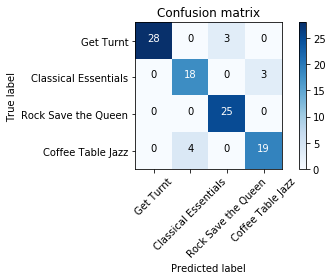

In [303]:
y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=playlist_dict, normalize=False,
                      title='Confusion matrix')
plt.show()

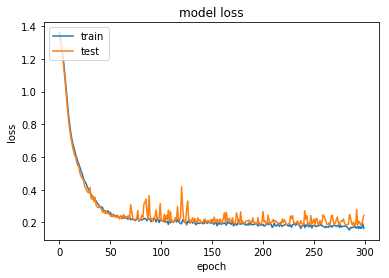

In [304]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()